# Comparing Predictions

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


plt.style.use("ggplot")

In [34]:
pred_names = [f.stem for f in Path("results").iterdir()]
pred_names

['deepensemble_pred', 'qr_preds22', 'qr_preds']

## Overall Model Comparison

Choose one or more of `pred_names` list above for comparison


In [35]:
use_preds = ["qr_preds22", "deepensemble_pred"]

def read_files(names: list[str], folder: str) -> pd.DataFrame:
    res_list = []
    for name in names:
        res = pd.read_csv(f"{folder}/{name}.csv")
        res["pred_name"] = name
        res_list.append(res)
    return pd.concat(res_list, ignore_index=True)

res = read_files(use_preds, "results")

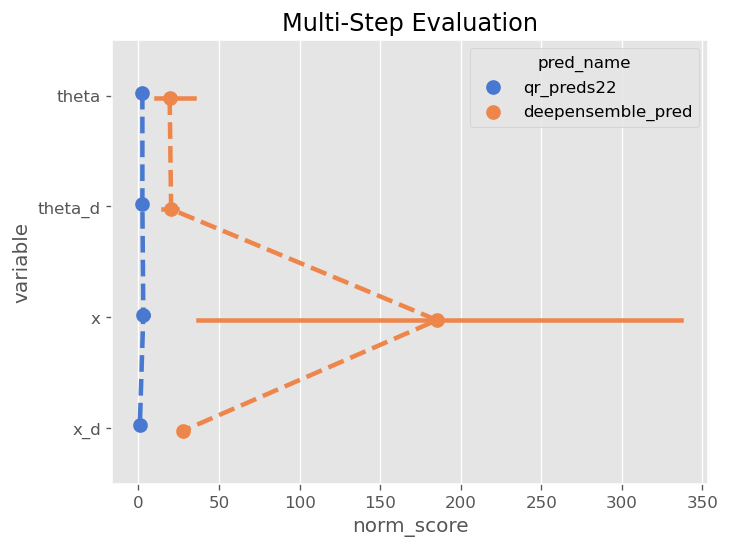

In [36]:
fig, ax = plt.subplots(dpi=120)
sns.pointplot(
    data=res.query("eval_mode == 'multi'"),
    x="norm_score",
    y="variable",
    hue="pred_name",
    orient="h",
    palette="muted",
    dodge=True,
    ax=ax,
    linestyles="--",
    errorbar="ci",
    order=["theta", "theta_d", "x", "x_d"]
)
ax.set_title("Multi-Step Evaluation")
plt.show()
#fig.savefig("deepensemble_multi_step.png")

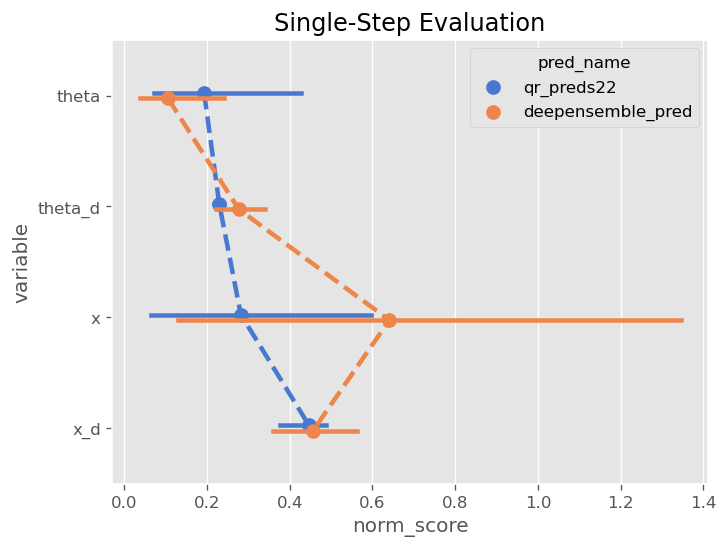

In [37]:
fig, ax = plt.subplots(dpi=120)
sns.pointplot(
    data=res.query("eval_mode == 'single'"),
    x="norm_score",
    y="variable",
    hue="pred_name",
    orient="h",
    palette="muted",
    dodge=True,
    ax=ax,
    linestyles="--",
    errorbar="ci",
    order=["theta", "theta_d", "x", "x_d"]
)
ax.set_title("Single-Step Evaluation")
plt.show()
#fig.savefig("deepensemble_single_step.png")

## Comparison Breakdown

Only models whose evaluations are saved in the `full_results` folder can be evaluated here. These are shown in the output of the next cell.

In [30]:
full_pred_names = [f.stem for f in Path("full_results").iterdir()]
full_pred_names

['deepensemble_pred', 'qr_preds', 'qr_preds22']

In [31]:
use_full_preds = use_preds

res_full = read_files(use_full_preds, "full_results")

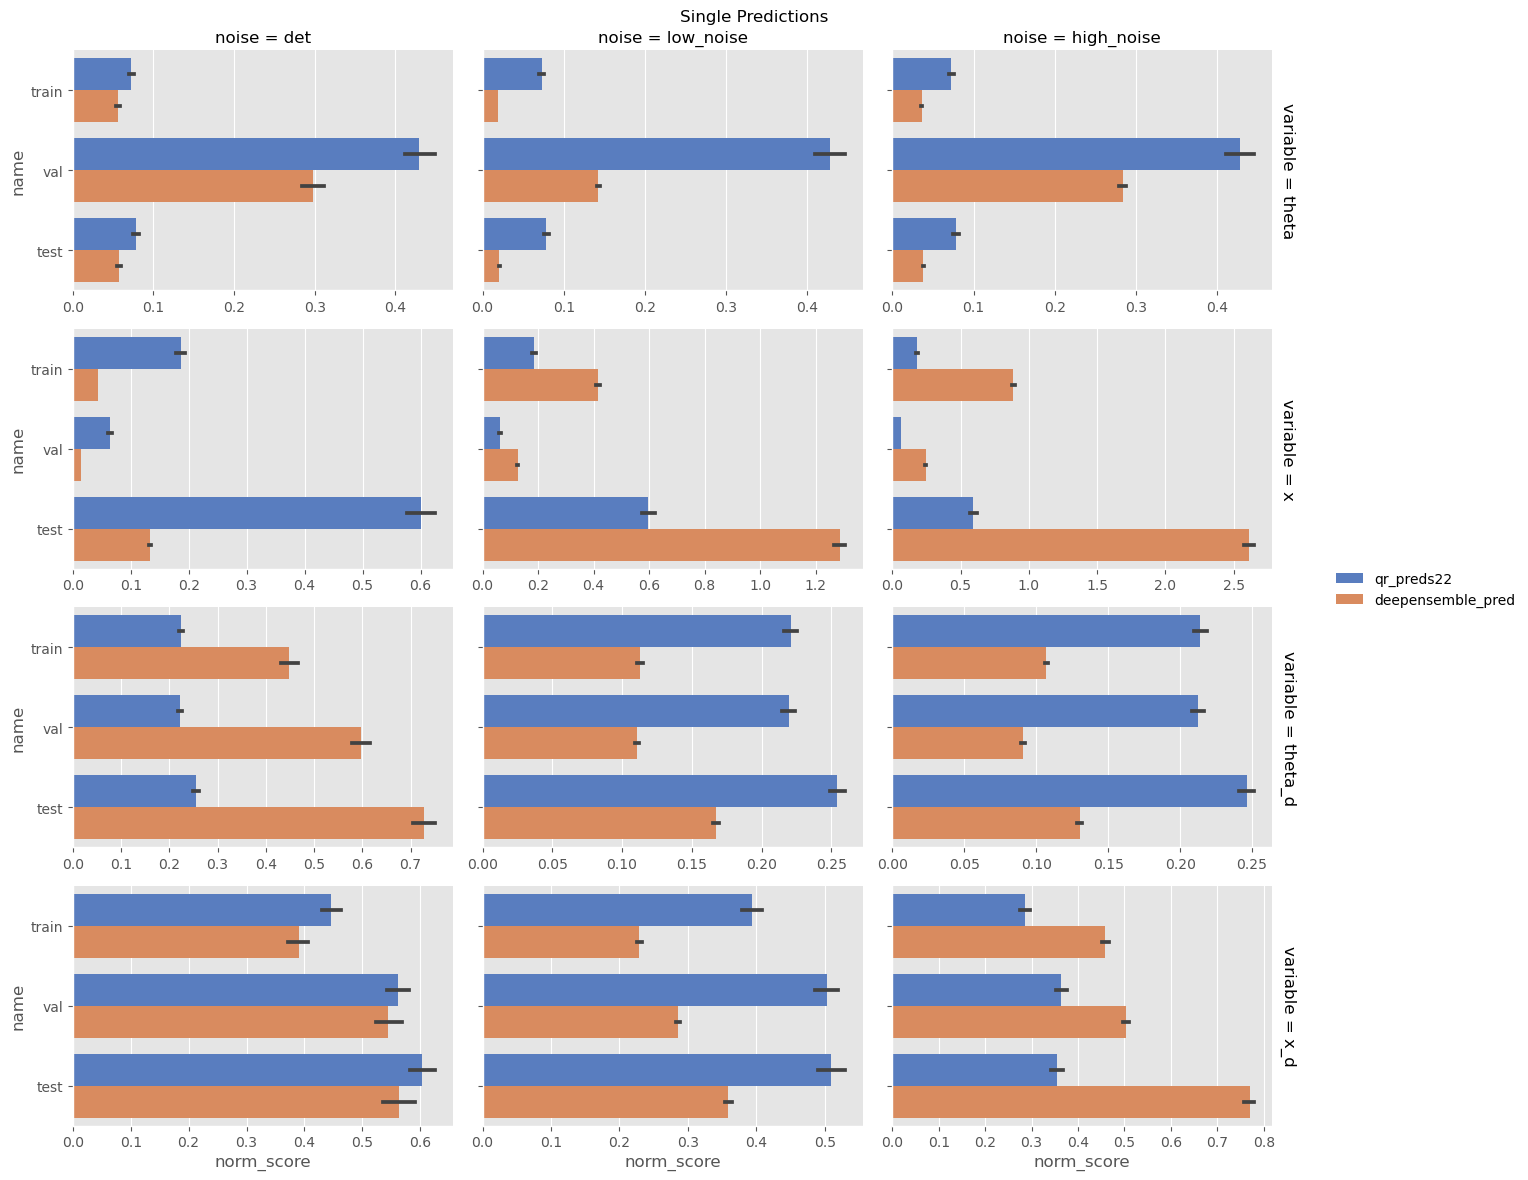

In [32]:

g = sns.FacetGrid(res_full.query("eval_mode == 'single'"), row="variable", col="noise", aspect=1.5, margin_titles=True, sharex=False)
g.map_dataframe(sns.barplot, x="norm_score", y="name", hue="pred_name", orient="h", palette="muted")
g.fig.suptitle("Single Predictions")
g.fig.tight_layout()
g.add_legend()
plt.show()
#g.savefig("deepensemble_single_step_full.png")

In [ ]:

g = sns.FacetGrid(res_full.query("eval_mode == 'single'"), row="variable", col="noise", aspect=1.5, margin_titles=True, sharex=False)
g.map_dataframe(sns.barplot, x="norm_score", y="name", hue="pred_name", orient="h", palette="muted")
g.fig.suptitle("Single Predictions")
g.fig.tight_layout()
g.add_legend()
plt.show()
#g.savefig("deepensemble_multi_step_full.png")

## Visuals from a single Model

This section is for inspecting the predictions themselves, especially multi-step

In [ ]:
pred_name = "qr_preds22"
pred_name = "deepensemble_pred"
preds = pd.read_csv(f"predictions/{pred_name}.csv")
preds

### Plot Single Trajectory

In [ ]:

variable = "theta"
if variable == "theta":
    nice_var = f"$\\{variable}$"
else:
    nice_var = "x"
noise = "det"
name = "val"
eval_mode = "multi"
start_row = 0
nrows = 1000

# Helper Function
def qdf(df, vars):
    qstr = " & ".join(f"{var} == @{var}" for var in vars)
    return df.query(qstr)

# Filtered data
tmp = qdf(preds, ["name", "variable", "noise", "eval_mode"]).set_index("t").iloc[start_row:nrows]

# Plot
fig, ax = plt.subplots(dpi=120)
for i, lev in enumerate([95, 80, 50]):
    ax.fill_between(
        tmp.index,
        y1=tmp[f"lower_{lev}"],
        y2=tmp[f"upper_{lev}"],
        color=str(0.9 - 0.15 * (i + 1)),
        label="",
    )
tmp[["actual"]].plot(ax=ax)
ax.set_ylabel(nice_var)

plt.show()

In [ ]:

variable = "theta"
if variable == "theta":
    nice_var = f"$\\{variable}$"
else:
    nice_var = "x"
noise = "det"
name = "val"
eval_mode = "single"
start_row = 0
nrows = 1000

# Helper Function
def qdf(df, vars):
    qstr = " & ".join(f"{var} == @{var}" for var in vars)
    return df.query(qstr)

# Filtered data
tmp = qdf(preds, ["name", "variable", "noise", "eval_mode"]).set_index("t").iloc[start_row:nrows]

# Plot
fig, ax = plt.subplots(dpi=120)
for i, lev in enumerate([95, 80, 50]):
    ax.fill_between(
        tmp.index,
        y1=tmp[f"lower_{lev}"],
        y2=tmp[f"upper_{lev}"],
        color=str(0.9 - 0.15 * (i + 1)),
        label="",
    )
tmp[["actual"]].plot(ax=ax)
ax.set_ylabel(nice_var)

plt.show()

### Plot all Trajectories from one Model

In [ ]:
# Nice plot
noise = "high_noise"
name = "test"
eval_mode = "multi"
nrows = 10000  # seconds times 100

# Filtered data
df_filt = qdf(preds, ["noise", "name", "eval_mode"]).set_index("t")

name_lookup = {
    "det": "No Noise",
    "low_noise": "0.1 Gaussian Noise",
    "high_noise": "0.5 Gaussian Noise",
}
data_lookup = {
    "train": "Training Data",
    "valid": "Extending Trajectories",
    "val": "Extending Trajectories",
    "test": "New Starting Position and Control Policy",
}
var_lookup = {
    "theta": r"$\theta$",
    "theta_d": r"$\dot{\theta}$",
    "x": r"$x$",
    "x_d": r"$\dot{x}$",
}
nice_name = ", ".join([pred_name, name_lookup[noise], data_lookup[name]])


# Plot
fig, axes = plt.subplots(nrows=4, figsize=(10, 12))
for var, ax in zip(var_lookup, axes):
    tmp = df_filt[df_filt.variable == var].iloc[:nrows]
    for i, lev in enumerate([95, 80, 50]):
        ax.fill_between(
            tmp.index,
            y1=tmp[f"lower_{lev}"],
            y2=tmp[f"upper_{lev}"],
            color=str(0.9 - 0.15 * (i + 1)),
            label="",
        )
    tmp[["actual"]].plot(ax=ax)
    ax.set_ylabel(var_lookup[var], rotation=0)
fig.suptitle(nice_name, fontsize=20)
fig.tight_layout()
plt.show()

In [ ]:
# Nice plot
noise = "high_noise"
name = "test"
eval_mode = "single"
nrows = 10000  # seconds times 100

# Filtered data
df_filt = qdf(preds, ["noise", "eval_mode"]).set_index("t")
# df_filt = qdf(preds, ["noise", "name", "eval_mode"]).set_index("t")

name_lookup = {
    "det": "No Noise",
    "low_noise": "0.1 Gaussian Noise",
    "high_noise": "0.5 Gaussian Noise",
}
data_lookup = {
    "train": "Training Data",
    # "valid": "Extending Trajectories",
    "val": "Extending Trajectories",
    "test": "New Starting Position and Control Policy",
}
var_lookup = {
    "theta": r"$\theta$",
    # "theta_d": r"$\dot{\theta}$",
    "theta_d": r"$\frac{d\theta}{dt}$",
    "x": r"$x$",
    "x_d": r"$\frac{dx}{dt}$",
}
nice_name = ", ".join([pred_name, name_lookup[noise]])
nice_name = ", ".join(["Gradient Boosting", name_lookup[noise]])


# Plot
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 12))
for j, data_name in enumerate(data_lookup):
    for vi, var in enumerate(var_lookup):
        ax = axes[vi, j]
        tmp = df_filt[(df_filt.variable == var) & (df_filt.name == data_name)].iloc[:nrows]
        for i, lev in enumerate([95, 80, 50]):
            ax.fill_between(
                tmp.index,
                y1=tmp[f"lower_{lev}"],
                y2=tmp[f"upper_{lev}"],
                color=str(0.9 - 0.15 * (i + 1)),
                label=f"{lev}% Interval",
            )
        tmp[["actual"]].plot(ax=ax)
        
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.legend([])
        if j == 0:
            ax.set_ylabel(var_lookup[var], rotation=0, fontsize=20)
        if vi == 0:
            ax.set_title(data_lookup[data_name], fontsize=20)
        if vi == 3:
            ax.set_xlabel("Time (seconds)", fontsize=16)
fig.suptitle(nice_name, fontsize=20)
handles, labels = ax.get_legend_handles_labels()
labels[-1] = "Actual"
lgd = ax.legend(reversed(handles), reversed(labels), loc='right', bbox_to_anchor=(1.125, 0.5), fontsize=20, bbox_transform=fig.transFigure)
title = fig.suptitle(nice_name, fontsize=20)
plt.show()
# fig.savefig("Performance.png", bbox_inches="tight", bbox_extra_artists=(lgd,title))

In [ ]:
from evaluate import eval_preds


# Nice plot
noise = "det"
name = "test"
eval_mode = "single"
nrows = 10000  # seconds times 100

# Filtered data
preds_eval = eval_preds(preds)
df_filt = qdf(preds_eval, ["noise", "eval_mode"]).set_index("t")
# df_filt = qdf(preds, ["noise", "name", "eval_mode"]).set_index("t")

name_lookup = {
    "det": "No Noise",
    "low_noise": "0.1 Gaussian Noise",
    "high_noise": "0.5 Gaussian Noise",
}
data_lookup = {
    "train": "Training Data",
    # "valid": "Extending Trajectories",
    "val": "Extending Trajectories",
    "test": "New Starting Position and Control Policy",
}
var_lookup = {
    "theta": r"$\theta$",
    # "theta_d": r"$\dot{\theta}$",
    "theta_d": r"$\frac{d\theta}{dt}$",
    "x": r"$x$",
    "x_d": r"$\frac{dx}{dt}$",
}
nice_name = ", ".join(["Interval Scores", "Gradient Boosting", name_lookup[noise]])
# nice_name = ", ".join([pred_name, name_lookup[noise], data_lookup[name]])


# Plot
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 12))
for j, data_name in enumerate(data_lookup):
    for vi, var in enumerate(var_lookup):
        ax = axes[vi, j]
        tmp = df_filt[(df_filt.variable == var) & (df_filt.name == data_name)].iloc[:nrows].reset_index()
        
        tmp.pivot_table(index="t", columns="interval", values="norm_score").plot(ax=ax)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.legend([])
        if j == 0:
            ax.set_ylabel(var_lookup[var], rotation=0, fontsize=20)
        if vi == 0:
            ax.set_title(data_lookup[data_name], fontsize=20)
        if vi == 3:
            ax.set_xlabel("Time (seconds)", fontsize=16)
handles, labels = ax.get_legend_handles_labels()
labels = [f"{val}% Interval Score" for val in labels]
# labels[-1] = "Actual"
# fig.tight_layout()
# fig.tight_layout(rect=[0,0,0.75, 1])
# lgd = fig.legend(reversed(handles), reversed(labels), loc="outside right center", fontsize=20)
lgd = ax.legend(reversed(handles), reversed(labels), loc='right', bbox_to_anchor=(1.125, 0.5), fontsize=20, bbox_transform=fig.transFigure)
title = fig.suptitle(nice_name, fontsize=20)
plt.show()
# fig.savefig("winkler.png", bbox_inches="tight", bbox_extra_artists=(lgd,title))

In [ ]:
preds_eval[(preds_eval.variable == "x") & (preds_eval.noise == "high_noise") & (preds_eval.name == "train") & (preds_eval.interval == 95)]


In [ ]:
from evaluate import create_actuals_lookup
datapath = Path.cwd().parents[1] / "Data/cartpoleData"
act = create_actuals_lookup(datapath)
display(act[(act.variable == "x") & (act.noise == "high_noise") & (act.name == "train")].head(30))
preds[(preds.variable == "x") & (preds.noise == "high_noise") & (preds.name == "train")].head(30)


In [ ]:
preds[preds.variable == "x"].head(30)

In [ ]:
?eval_preds

In [ ]:
tmp

In [ ]:
# avg_dist = (
#     tmp.query("noise == 'det'")
#     .groupby(["variable", "name", "eval_mode"], as_index=False)["actual"]
#     .apply(lambda x: (x - x.iloc[0]).abs().mean())
#     .rename(columns={"actual": "avg_dist"})
# )
tmp